In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv("C:\\Users\\fake_job_postings.csv")

data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
# Check for missing values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_data = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
print(missing_data[missing_data["Missing Values"] > 0])

# Handle missing values:
# Numerical columns - fill missing with median value
numerical_columns = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
for col in numerical_columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)


                     Missing Values  Percentage
location                        346    1.935123
department                    11547   64.580537
salary_range                  15012   83.959732
company_profile                3308   18.501119
description                       1    0.005593
requirements                   2696   15.078300
benefits                       7212   40.335570
employment_type                3471   19.412752
required_experience            7050   39.429530
required_education             8105   45.329978
industry                       4903   27.421700
function                       6455   36.101790


In [10]:
# Categorical columns - fill missing with "Unknown"
categorical_columns = ['title', 'location', 'department', 'salary_range', 'company_profile', 
                       'description', 'requirements', 'benefits', 'employment_type', 
                       'required_experience', 'required_education', 'industry', 'function']
for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna("Unknown", inplace=True)

# Check missing values again after filling
print(data.isnull().sum())


job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64


In [11]:
# Prepare features and target
X = data.drop(columns=['fraudulent'])
y = data['fraudulent']

# Combine text columns for NLP
data['text'] = data[['title', 'location', 'company_profile', 'description', 'requirements', 'benefits', 'industry']].astype(str).agg(' '.join, axis=1)

# Drop original text columns after combining them into 'text'
drop_text_columns = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'required_experience', 'required_education', 'industry', 'function', 'country', 'employment_type']
data.drop(columns=[col for col in drop_text_columns if col in data.columns], inplace=True)

# Encode categorical columns using LabelEncoder
categorical_columns = ['required_experience', 'required_education', 'employment_type']
label_encoder = LabelEncoder()
for col in categorical_columns:
    if col in data.columns:
        data[col] = label_encoder.fit_transform(data[col].astype(str))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


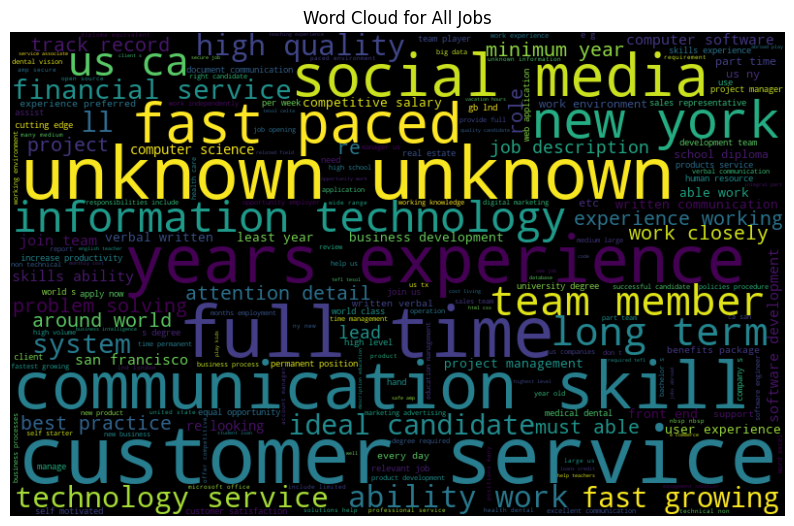

In [14]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
data['text'] = data['text'].str.lower().apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

all_words = ' '.join(data['text'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=120).generate(all_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for All Jobs")
plt.show()


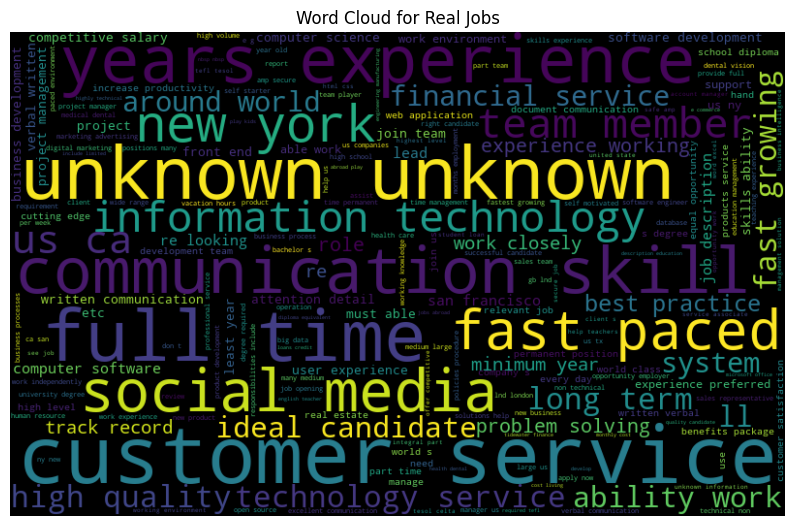

In [15]:
real_words = ' '.join(data['text'][data['fraudulent'] == 0])
wordcloud_real = WordCloud(width=800, height=500, random_state=21, max_font_size=120).generate(real_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Real Jobs")
plt.show()

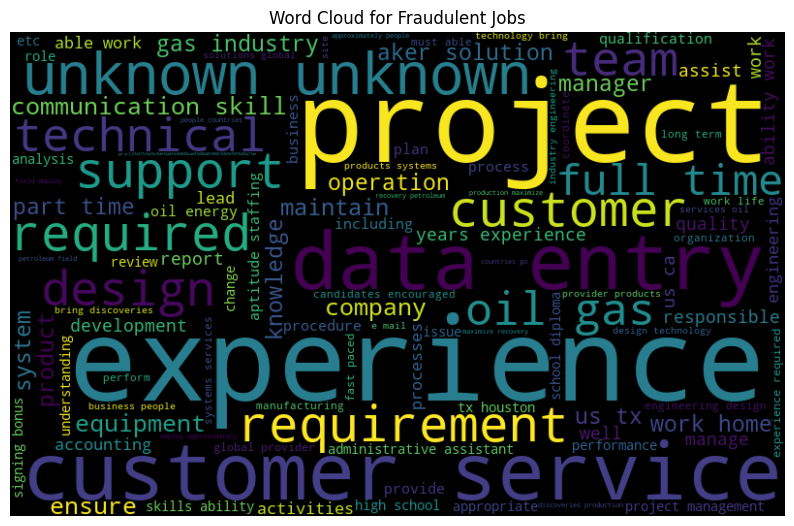

In [16]:
fraud_words = ' '.join(data['text'][data['fraudulent'] == 1])
wordcloud_fraud = WordCloud(width=800, height=500, random_state=21, max_font_size=120).generate(fraud_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_fraud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Fraudulent Jobs")
plt.show()

Accuracy: 0.9745525727069351
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.88      0.58      0.70       181

    accuracy                           0.97      3576
   macro avg       0.93      0.79      0.84      3576
weighted avg       0.97      0.97      0.97      3576



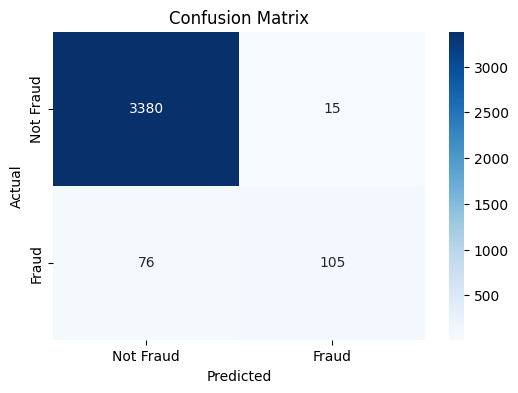

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['fraudulent'], test_size=0.2, random_state=42)

# Text vectorization
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# Model training and evaluation
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred = nb.predict(X_test_dtm)

# Output accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()